In [1]:
import os
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import monai
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from itkwidgets import view

from torch.utils.tensorboard import SummaryWriter
import torch

import torchio as tio

%load_ext autoreload
%autoreload 2

from mbas.visualize.subject import plot_subject_with_label
from mbas.visualize.visualize import segmentation_label_color

2024-05-31 09:03:54.755943: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 09:03:55.685873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 09:03:56.664312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_dir = "/home/bryan/data/MBAS/Training"

In [3]:
patient_id = "MBAS_050"
gt_file = os.path.join(data_dir, patient_id, f"{patient_id}_gt.nii.gz")
label_file = os.path.join(data_dir, patient_id, f"{patient_id}_label.nii.gz")

In [4]:
subject = tio.Subject(
    label = tio.LabelMap(path = label_file, name = "label"),
    mri = tio.ScalarImage(path=gt_file, name = "mri"),
    patient_id = patient_id,
)

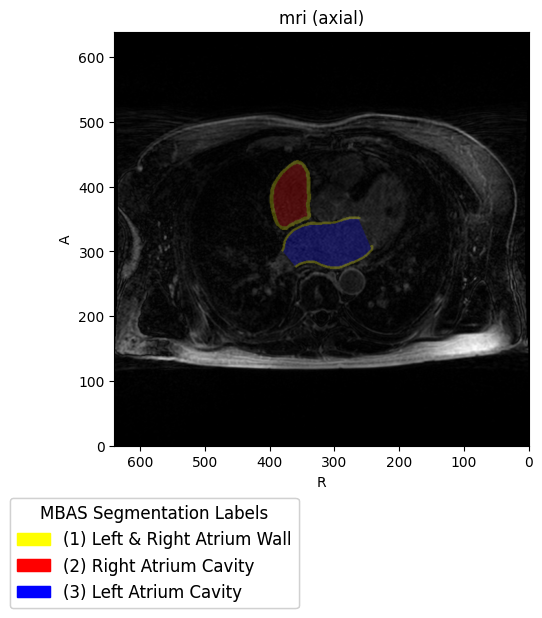

In [5]:
plot_subject_with_label(
    subject,
    show=True,
    add_metadata=False,
    add_segmentation_legend=True,
    single_axis="axial",
    label_key="label",
    cmap="mbas",
#     indices = (300, 300, 40)
#     subject_include=["fla"]
);

In [6]:
subject.mri

ScalarImage(shape: (1, 640, 640, 44); spacing: (0.62, 0.62, 2.50); orientation: LPS+; path: "/home/bryan/data/MBAS/Training/MBAS_050/MBAS_050_gt.nii.gz")

In [ ]:
counts = np.zeros(4)
for x in subject.label.data.flatten().tolist():
    counts[int(x)] += 1

In [ ]:
import matplotlib
import matplotlib.cm as cm
from collections import OrderedDict
MBAS_LABEL_COLORS = OrderedDict({
    0: "black",
    1: "red",
    2: "blue",
    3: "yellow"
})
mbas_colormap = matplotlib.colors.ListedColormap(MBAS_LABEL_COLORS.values(), name = "mbas")
matplotlib.colormaps.register(mbas_colormap)

In [ ]:
MBAS_LABEL_COLORS.values()

In [ ]:
from torchio.visualization import color_labels, rotate
from torchio.transforms.preprocessing.spatial.to_canonical import ToCanonical

reorient = True
channel = -1
indices = 30
radiological = True
def prepare_slices(im):
    if reorient:
        im = ToCanonical()(im)  # type: ignore[assignment]
    data = im.data[channel]
    indices_ = indices
    if indices_ is None:
        indices_ = np.array(data.shape) // 2
    i, j, k = indices_
    slice_x = rotate(data[i, :, :], radiological=radiological)
    slice_y = rotate(data[:, j, :], radiological=radiological)
    slice_z = rotate(data[:, :, k], radiological=radiological)
    return slice_x, slice_y, slice_z

border_color = None
def blend_slice(mri_slice, label_slice):
    blend = blend_images(
        image=np.expand_dims(mri_slice, 0),
        label=np.expand_dims(label_slice, 0),
        alpha=0.25,
        cmap="mbas",
        rescale_arrays=True,
    )
    blend = 255.0 * blend
    blend = blend.astype(np.uint8)
    blend = np.moveaxis(blend, 0, -1)  # CHW -> HWC
    blend = np.ascontiguousarray(blend)
    if border_color is not None:
        blend = add_color_border(blend, border_width, border_color)
    return blend

In [ ]:
_, _, mri_slice = prepare_slices(subject.mri)
_, _, label_slice = prepare_slices(subject.label)

In [ ]:
mri_vis = blend_slice(mri_slice, label_slice)

In [ ]:
Image.fromarray(mri_vis)

In [ ]:
matplotlib.colormaps["hsv"]

In [ ]:
colors = segmentation_label_color([0, 1, 2, 3], cmap = "hsv", rgb_255 = False)
colors

In [ ]:
import matplotlib.patches as mpatches
from mbas.data.constants import MBAS_LABELS

In [ ]:
MBAS_LABELS

In [ ]:
MBAS_LABEL_COLORS = {
    1: "red",
    2: "blue",
    3: "yellow"
}

In [ ]:
fig, ax = plt.subplots()
patches = [
    mpatches.Patch(color = MBAS_LABEL_COLORS[i], label = MBAS_LABELS[i])
    for i in [1,2,3]
]
ax.legend(handles = patches)
plt.show()